In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. CARREGAMENTO E LIMPEZA ---
df = pd.read_csv('cStick.csv')


# Remover espaços dos nomes das colunas
df.columns = df.columns.str.strip()
print('Colunas disponíveis no CSV:', list(df.columns))

# Definindo as Features (Sensores) e o Target (Decisão)
features = ['Distance', 'Pressure', 'HRV', 'Sugar level', 'SpO2', 'Accelerometer']
target = 'Decision'

X = df[features]  # Dados de entrada
y = df[target]    # O que queremos prever (multiclasse: 0, 1, 2)

Colunas disponíveis no CSV: ['Distance', 'Pressure', 'HRV', 'Sugar level', 'SpO2', 'Accelerometer', 'Decision']


In [67]:
# --- 2. DIVISÃO TREINO E TESTE ---
# 80% para treinar a IA, 20% para prova (teste) com estratificação por classe
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [68]:
# --- 2b. Pré-processamento para NN (escala) ---
from sklearn.preprocessing import StandardScaler

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn = scaler_nn.transform(X_test)

num_classes = len(sorted(y.unique()))
print(f"Classes detectadas: {sorted(y.unique())} | num_classes={num_classes}")

Classes detectadas: [np.int64(0), np.int64(1), np.int64(2)] | num_classes=3


In [69]:
# --- 3b. Neural Network (PyTorch) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Preparar tensores
X_train_t = torch.tensor(X_train_nn, dtype=torch.float32)
X_test_t = torch.tensor(X_test_nn, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t = torch.tensor(y_test.values, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

input_dim = X_train_nn.shape[1]
num_classes = len(sorted(y.unique()))

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

model_nn = MLP(input_dim, num_classes)
optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 20
print(f"\n🔁 Treinando Rede Neural (PyTorch) por {epochs} épocas...")
for epoch in range(1, epochs+1):
    model_nn.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model_nn(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    train_loss = total_loss / total
    train_acc = correct / total

    # validação simples por época
    model_nn.eval()
    with torch.no_grad():
        v_loss = 0.0
        v_correct = 0
        v_total = 0
        for xb, yb in val_loader:
            logits = model_nn(xb)
            loss = criterion(logits, yb)
            v_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            v_correct += (preds == yb).sum().item()
            v_total += xb.size(0)
        val_loss = v_loss / v_total
        val_acc = v_correct / v_total
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc*100:.2f}% | val_loss={val_loss:.4f} acc={val_acc*100:.2f}%")

# Avaliação final
model_nn.eval()
with torch.no_grad():
    logits = model_nn(X_test_t)
    nn_loss = criterion(logits, y_test_t).item()
    y_pred_nn_labels = logits.argmax(dim=1).cpu().numpy()
    nn_acc = (y_pred_nn_labels == y_test.values).mean()

print(f"\n✅ NN Avaliação — Loss: {nn_loss:.4f} | Accuracy: {nn_acc*100:.2f}%")


🔁 Treinando Rede Neural (PyTorch) por 20 épocas...
Epoch 01 | train_loss=0.6658 acc=83.57% | val_loss=0.2485 acc=100.00%
Epoch 02 | train_loss=0.1122 acc=100.00% | val_loss=0.0220 acc=100.00%
Epoch 03 | train_loss=0.0185 acc=100.00% | val_loss=0.0056 acc=100.00%
Epoch 04 | train_loss=0.0080 acc=100.00% | val_loss=0.0022 acc=100.00%
Epoch 02 | train_loss=0.1122 acc=100.00% | val_loss=0.0220 acc=100.00%
Epoch 03 | train_loss=0.0185 acc=100.00% | val_loss=0.0056 acc=100.00%
Epoch 04 | train_loss=0.0080 acc=100.00% | val_loss=0.0022 acc=100.00%
Epoch 05 | train_loss=0.0040 acc=100.00% | val_loss=0.0011 acc=100.00%
Epoch 06 | train_loss=0.0025 acc=100.00% | val_loss=0.0007 acc=100.00%
Epoch 07 | train_loss=0.0017 acc=100.00% | val_loss=0.0005 acc=100.00%
Epoch 05 | train_loss=0.0040 acc=100.00% | val_loss=0.0011 acc=100.00%
Epoch 06 | train_loss=0.0025 acc=100.00% | val_loss=0.0007 acc=100.00%
Epoch 07 | train_loss=0.0017 acc=100.00% | val_loss=0.0005 acc=100.00%
Epoch 08 | train_loss=0.00

In [70]:
# --- 3. TREINAMENTO DO MODELO ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [71]:
# --- 4. AVALIAÇÃO DE RESULTADOS ---
y_pred = model.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
print(f"\nTreinamento Concluído!")
print(f"Acurácia do Modelo: {acuracia * 100:.2f}%")
print("\nRelatório Random Forest:")
print(classification_report(y_test, y_pred))

print('\n📄 Relatório NN:')
print(classification_report(y_test, y_pred_nn_labels))


Treinamento Concluído!
Acurácia do Modelo: 100.00%

Relatório Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       137
           2       1.00      1.00      1.00       133

    accuracy                           1.00       408
   macro avg       1.00      1.00      1.00       408
weighted avg       1.00      1.00      1.00       408


📄 Relatório NN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       137
           2       1.00      1.00      1.00       133

    accuracy                           1.00       408
   macro avg       1.00      1.00      1.00       408
weighted avg       1.00      1.00      1.00       408



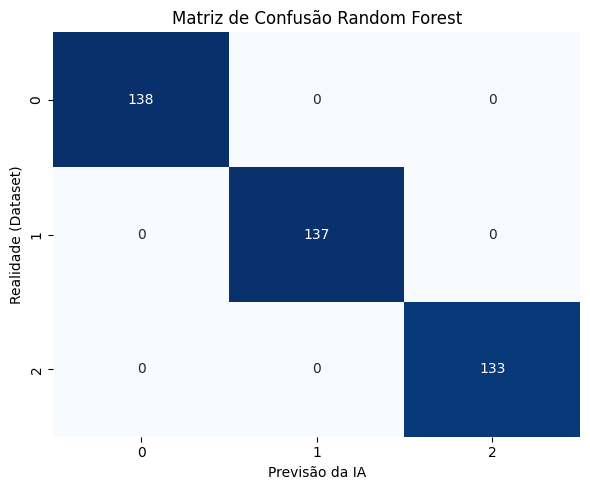

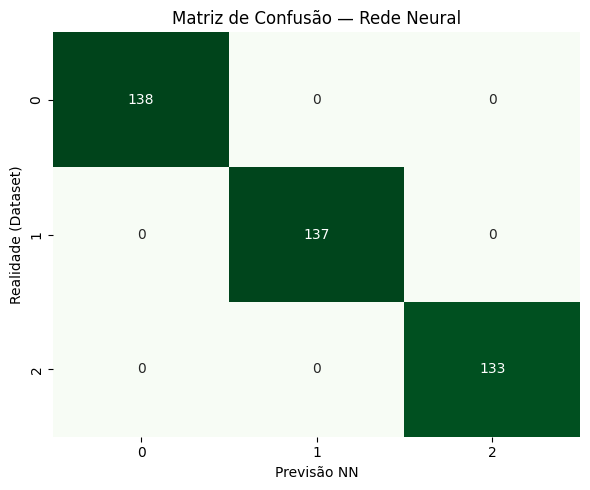

In [72]:
# --- 5. GERAÇÃO DE GRÁFICOS PARA O RELATÓRIO ---

# Gráfico A: Matriz de Confusão (Random Forest)
plt.figure(figsize=(6, 5))
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão Random Forest')
plt.xlabel('Previsão da IA')
plt.ylabel('Realidade (Dataset)')
plt.tight_layout()
plt.show()

# --- 5b. Comparação RF vs NN ---
from sklearn.metrics import classification_report

# Matriz de confusão NN
plt.figure(figsize=(6,5))
labels = sorted(y.unique())
cm_nn = confusion_matrix(y_test, y_pred_nn_labels, labels=labels)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão — Rede Neural')
plt.xlabel('Previsão NN')
plt.ylabel('Realidade (Dataset)')
plt.tight_layout()
plt.show()

In [73]:
# --- 5c. Sumário consolidado de resultados ---
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Métricas globais (macro) para RF
prec_rf, rec_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
# Métricas globais (macro) para NN
prec_nn, rec_nn, f1_nn, _ = precision_recall_fscore_support(y_test, y_pred_nn_labels, average='macro', zero_division=0)

summary = pd.DataFrame({
    'Modelo': ['RandomForest', 'NeuralNet (PyTorch)'],
    'Acurácia (%)': [acuracia*100, nn_acc*100],
    'Precisão (macro)': [prec_rf, prec_nn],
    'Recall (macro)': [rec_rf, rec_nn],
    'F1 (macro)': [f1_rf, f1_nn]
}).round(3)

print('\n📈 Sumário Consolidado de Desempenho:')
display(summary)

print('\n📄 Relatório por classe — RandomForest:')
print(classification_report(y_test, y_pred))

print('\n📄 Relatório por classe — NeuralNet (PyTorch):')
print(classification_report(y_test, y_pred_nn_labels))


📈 Sumário Consolidado de Desempenho:


,Modelo,Acurácia (%),Precisão (macro),Recall (macro),F1 (macro)
0,RandomForest,100.0,1.0,1.0,1.0
1,NeuralNet (PyTorch),100.0,1.0,1.0,1.0



📄 Relatório por classe — RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       137
           2       1.00      1.00      1.00       133

    accuracy                           1.00       408
   macro avg       1.00      1.00      1.00       408
weighted avg       1.00      1.00      1.00       408


📄 Relatório por classe — NeuralNet (PyTorch):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00       137
           2       1.00      1.00      1.00       133

    accuracy                           1.00       408
   macro avg       1.00      1.00      1.00       408
weighted avg       1.00      1.00      1.00       408



In [74]:
# --- 6. SALVAR OS MODELOS PARA O APP ---
import pickle
import torch

# Random Forest
with open('modelo_RdF.pkl', 'wb') as f:
    pickle.dump(model, f)
print("\n💾 Modelo Random Forest salvo em 'modelo_RdF.pkl'.")

# Rede Neural (PyTorch)
# Para reutilização, salvamos o state_dict e também o scaler utilizado nas features
torch.save(model_nn.state_dict(), 'modelo_nn.pkl')
print("💾 Modelo NN (state_dict) salvo em 'modelo_nn.pkl'.")

with open('scaler_nn.pkl', 'wb') as f:
    pickle.dump(scaler_nn, f)
print("💾 Scaler das features para NN salvo em 'scaler_nn.pkl'.")


💾 Modelo Random Forest salvo em 'modelo_RdF.pkl'.
💾 Modelo NN (state_dict) salvo em 'modelo_nn.pkl'.
💾 Scaler das features para NN salvo em 'scaler_nn.pkl'.
